In [1]:
import sys

sys.path.append("/home/salmon/workspace/fytok_tutorial/python")

import typing
import numpy as np
from spdm.view import sp_view

from fytok.utils.logger import logger
from fytok.modules.equilibrium import Equilibrium
from fytok.modules.core_transport import CoreTransport   
from fytok.modules.core_profiles import CoreProfiles   

2024-07-30 17:56:51,400 [    spdm]     INFO: 
########################################################################################################################
        ______      _____     _
       / ____/_  __|_   _|__ | | __
      / /_  / / / /  | |/ _ \| |/ /
     / __/ / /_/ /   | | (_) |   <
    /_/    \__, /    |_|\___/|_|\_\
          /____/

(C) 2021-2024 Zhi YU @ ASIPP. All rights reserved.
version: develop, spdm: develop, ontology: imas/3
########################################################################################################################

2024-07-30 17:56:51,593 [   fytok]  VERBOSE: Using ontology: imas/3 (dummy) at fytok/mappings/{schema}/imas/3:spdm/mapping/{schema}/imas/3


# 数据绑定

In [2]:
eq = Equilibrium("file+geqdsk://./data/geqdsk.txt#equilibrium")

2024-07-30 17:56:51,948 [   fytok]  VERBOSE: Load module fytok.plugins.modules.equilibrium.fy_eq
2024-07-30 17:56:51,951 [   fytok]  VERBOSE: Load module spdm.plugins.data.file_geqdsk


直接导入数据

In [3]:
core_profiles = CoreProfiles(
    {"vacuum_toroidal_field": {"r0": 5.2, "b0": 2.5}},  # 以 dict的形式传入参数
    profiles_1d={  # 以命名变量的形式子节点传入参数
        "electrons": {},
        "grid": eq.profiles_1d.grid.remesh(rho_tor_norm=np.linspace(0.01, 0.95, 128)),
        "ion": ["H", "D"],
    },
)
profiles_1d: CoreProfiles.Profiles1D = core_profiles.profiles_1d

2024-07-30 17:56:52,019 [   fytok]  VERBOSE: Load module spdm.mesh.mesh_rectangular


采用符号运算定义表达式

In [4]:
from spdm.core.expression import _x, _y, _z

对成员赋值

In [5]:
profiles_1d.zeff = np.sqrt(_x) * 2.0 
profiles_1d.electrons.density = np.sqrt(_x) * 1.0e19  # type:ignore
profiles_1d.electrons.temperature = (_x**2) * 1.0e5     
profiles_1d.ion["H"].density = np.sqrt(_x) * 1.0e19   # type:ignore
profiles_1d.ion["H"].temperature = (_x**2) * 1.0e5

访问成员

2024-07-30 17:56:53,998 [   fytok]  VERBOSE: Load module spdm.view.view_matplotlib


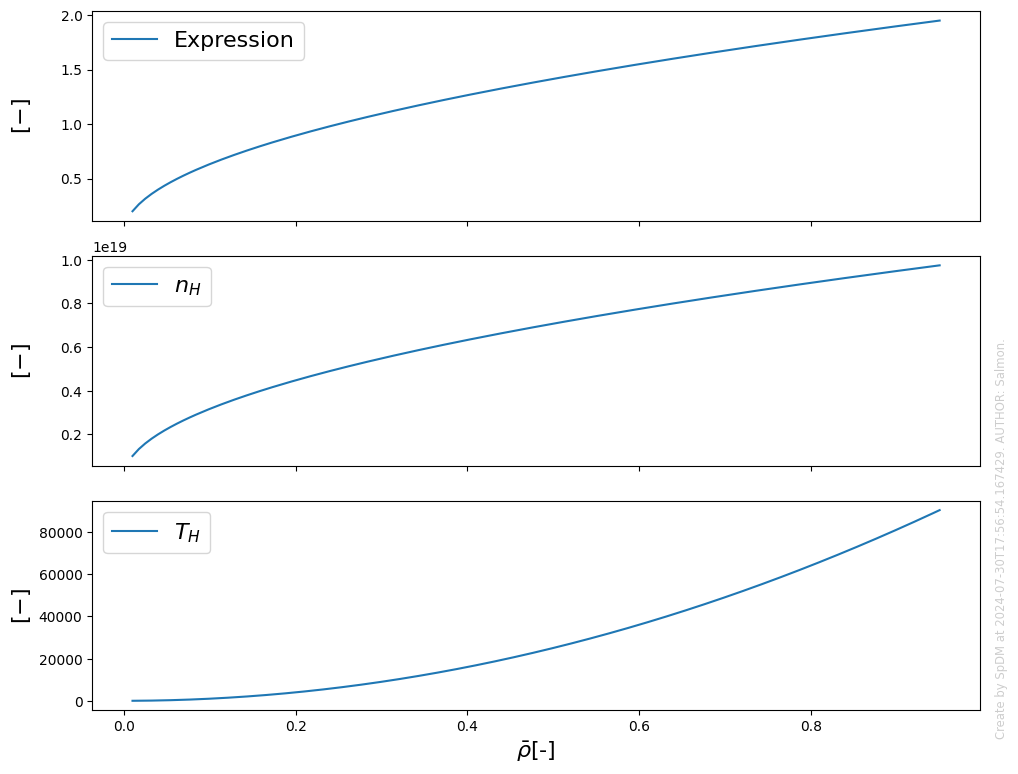

In [6]:
fig = sp_view.plot(
    (profiles_1d.grid.rho_tor_norm, r"$\bar{\rho}$[-]"),
    profiles_1d.zeff,
    (profiles_1d.ion["H"].density, r"$n_H$"),
    (profiles_1d.ion["H"].temperature, r"$T_H$"),
)

以统一资源描述符 URI 的形式导入数据源

In [7]:
core_profiles=CoreProfiles(f"file+iterprofiles://./data/profiles.xls#core_profiles")

2024-07-30 17:56:55,302 [   fytok]  VERBOSE: Load module spdm.plugins.data.file_iterprofiles


遍历访问成员

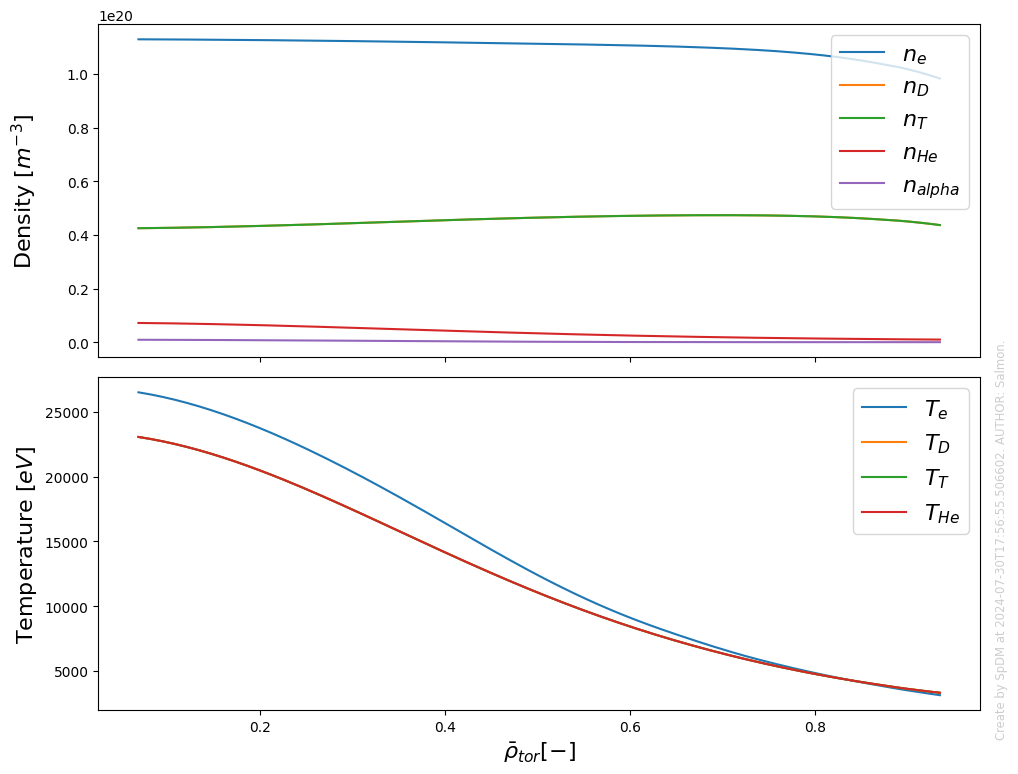

In [8]:
profiles = core_profiles.profiles_1d

fig = sp_view.plot(
    (profiles.grid.rho_tor_norm[10:-10], r"$\bar{\rho}_{tor}[-]$"),  # 横坐标
    (
        [
            (profiles.electrons.density, r"$n_e$"),
            *[
                (profile.density, f"$n_{{{profile.label}}}$")
                for profile in profiles.ion if not profile.is_impurity
            ],
        ],
        {"y_label": r"Density $[m^{-3}]$"},
    ),
    (
        [
            (profiles.electrons.temperature, r"$T_e$"),
            *[
                (profile.temperature, f"$T_{{{profile.label}}}$")
                for profile in profiles.ion if not profile.is_impurity
            ],
        ],
        {"y_label": r"Temperature $[eV]$"},
    ),
)

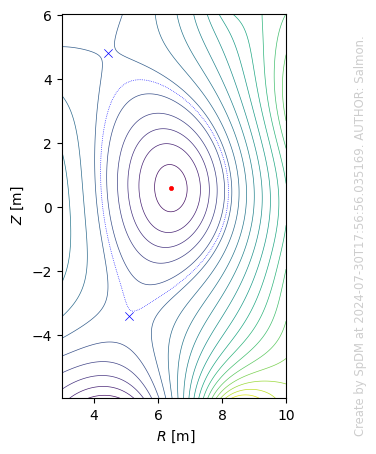

In [9]:
fig=sp_view.display(eq)

## 模块调用

In [10]:
class CoreTransportDemo(CoreTransport.Model, code={"name": "demo"}):
    """Plugin Demo: CoreTransportModel"""

    def execute(
        self, *args, equilibrium: Equilibrium, core_profiles: CoreProfiles, **kwargs
    ) -> typing.Self:
        res = super().execute(
            *args,
            equilibrium=equilibrium,
            core_profiles=core_profiles,
            **kwargs,
        )
        res_1d: CoreProfiles.Profiles1D = res.profiles_1d
        eq_1d: Equilibrium.Profiles1D = equilibrium.profiles_1d
        prof_1d: CoreProfiles.Profiles1D = core_profiles.profiles_1d
        psi_norm = res_1d.grid.psi_norm
        rho_tor_norm = res_1d.grid.rho_tor_norm

        res.profiles_1d.conductivity_parallel = np.sin(rho_tor_norm * 6.28)
        return res


spitzer = CoreTransportDemo()

In [11]:
spitzer.refresh(equilibrium=eq, core_profiles=core_profiles)

2024-07-30 17:56:56,206 [   fytok]    DEBUG: /home/salmon/workspace/spdm/python/spdm/model/process.py:70:execute: Execute: demo


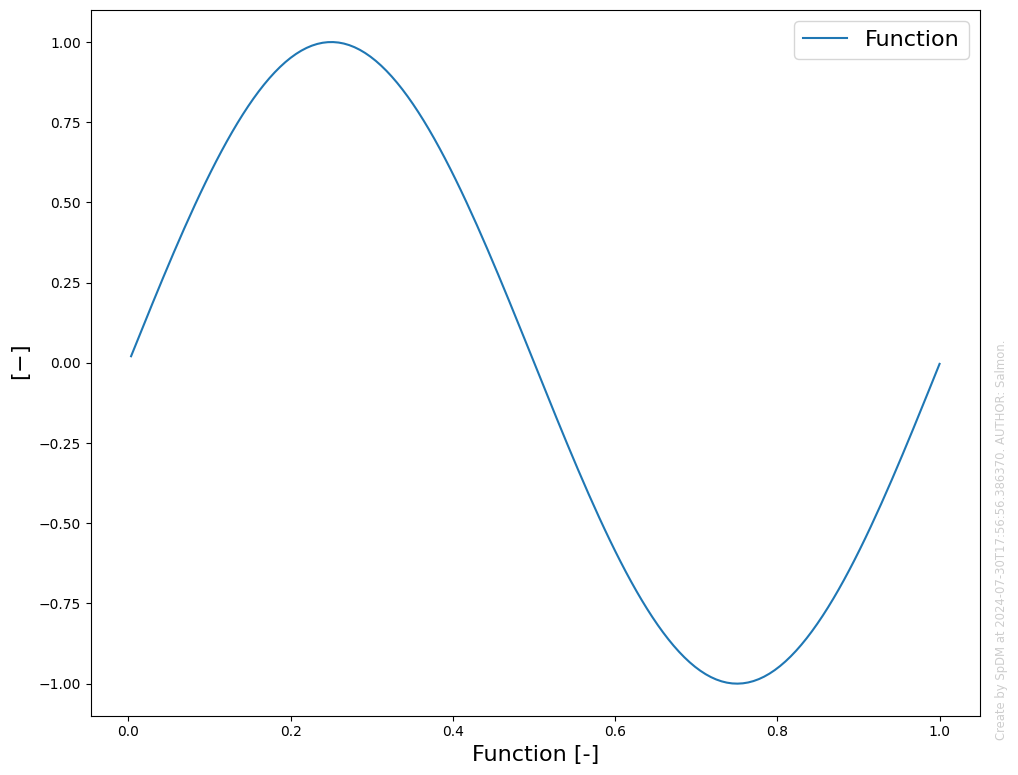

In [12]:
fig = sp_view.plot(
    spitzer.profiles_1d.rho_tor_norm, spitzer.profiles_1d.conductivity_parallel
)

## 插件

In [13]:
model = CoreTransport.Model(code={"name": "spitzer_demo"})

2024-07-30 17:56:56,544 [   fytok]  VERBOSE: Load module fytok.plugins.modules.core_transport.model.spitzer_demo


In [14]:
model.refresh(equilibrium=eq, core_profiles=core_profiles)

2024-07-30 17:56:56,560 [   fytok]    DEBUG: /home/salmon/workspace/spdm/python/spdm/model/process.py:70:execute: Execute: spitzer_demo


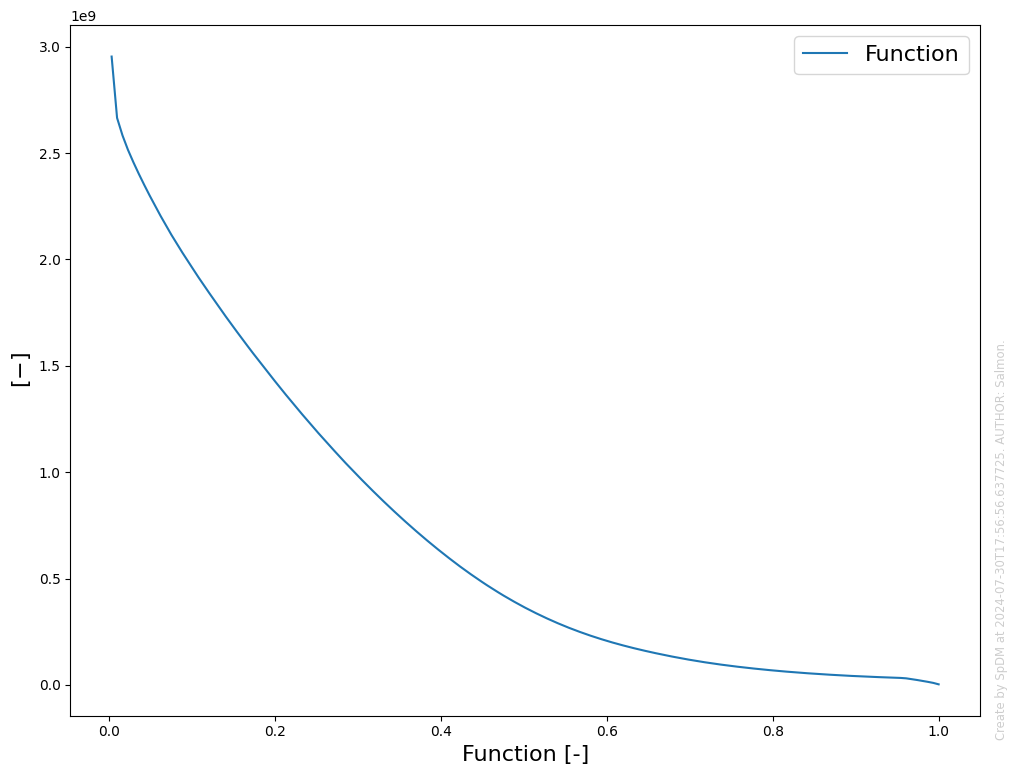

In [15]:
fig = sp_view.plot(
    model.profiles_1d.rho_tor_norm, model.profiles_1d.conductivity_parallel
)